In [1]:
!nvidia-smi

Thu Mar  2 15:26:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0  On |                  N/A |
|  0%   40C    P8    15W / 200W |    740MiB /  8192MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python3 -m pip install --upgrade setuptools pip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
import glob
import shutil
import cv2
import os
import re
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import PIL

In [4]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 103.0 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 171.5 MB/s eta 0:00:00


In [6]:
pwd

'/app'

In [7]:
ls /app/

Copy_of_YOloV5_.ipynb  annotations/  images/  yolov5s.pt
Untitled.ipynb         data/         yolov5/


In [15]:
cd /app

/app


In [16]:
ls 

 Copy_of_YOloV5_.ipynb   annotations/  'garbage classification'/   yolov5/
 Untitled.ipynb          data/          images/                    yolov5s.pt


In [54]:
base_dir = "/app/garbage classification/Garbage classification"
train_dir = os.path.join(base_dir, 'train')
train_img_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_img_dir = os.path.join(test_dir, 'images')
test_label_dir = os.path.join(test_dir, 'labels')


In [55]:
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [30]:
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [31]:
print(torch.__version__)

1.13.1+cu117


In [56]:
create_dir(train_dir)

In [57]:
create_dir(train_img_dir)
create_dir(train_label_dir)

In [58]:
create_dir(test_dir)
create_dir(test_img_dir)
create_dir(test_label_dir)

In [33]:
# visualize Classes
base_dir = "/app/garbage classification/Garbage classification"

classes = os.listdir(base_dir)

classes


['cardboard', 'test', 'metal', 'trash', 'train', 'glass', 'paper', 'plastic']

In [63]:
class_dirs = {name: os.path.join(base_dir, name) for name in classes}

In [64]:
class_dirs

{'cardboard': '/app/garbage classification/Garbage classification/cardboard',
 'test': '/app/garbage classification/Garbage classification/test',
 'metal': '/app/garbage classification/Garbage classification/metal',
 'trash': '/app/garbage classification/Garbage classification/trash',
 'train': '/app/garbage classification/Garbage classification/train',
 'glass': '/app/garbage classification/Garbage classification/glass',
 'paper': '/app/garbage classification/Garbage classification/paper',
 'plastic': '/app/garbage classification/Garbage classification/plastic'}

In [68]:
for class_name in classes:
    class_train_dir = os.path.join(train_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_test_dir, exist_ok=True)
    
    filenames = os.listdir(class_dirs[class_name])
    random.shuffle(filenames)
    
    
    split_idx = int(len(filenames) * 0.8)
    train_filenames = filenames[:split_idx]
    test_filenames = filenames[split_idx:]
    
    for filename in train_filenames:
        src_path = os.path.join(class_dirs[class_name], filename)
        dst_path = os.path.join(class_train_dir, filename)
        shutil.copyfile(src_path, dst_path)
        
        # Move test files   
    for filename in test_filenames:
        src_path = os.path.join(class_dirs[class_name], filename)
        dst_path = os.path.join(class_test_dir, filename)
        shutil.copyfile(src_path, dst_path)


IsADirectoryError: [Errno 21] Is a directory: '/app/garbage classification/Garbage classification/test/cardboard'

In [69]:
import os
import random
import shutil

dataset_dir = '/app/garbage classification/Garbage classification'
train_dir = '/app/garbage classification/Garbage classification/train'
test_dir = '/app/garbage classification/Garbage classification/test'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    train_class_dir = os.path.join(train_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)

    test_class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

    file_list = os.listdir(class_dir)
    file_list = [file for file in file_list if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png')]

    random.shuffle(file_list)
    train_files = file_list[:int(0.8*len(file_list))]
    test_files = file_list[int(0.8*len(file_list)):]

    for file in train_files:
        src_path = os.path.join(class_dir, file)
        dst_path = os.path.join(train_class_dir, file)
        shutil.move(src_path, dst_path)

    for file in test_files:
        src_path = os.path.join(class_dir, file)
        dst_path = os.path.join(test_class_dir, file)
        shutil.move(src_path, dst_path)


In [75]:

garbage_count=[]
garbage_class=[]
for i in os.listdir(base_dir+'/train'):
    garbage_class.append(i)
    garbage_count.append(len(os.listdir(os.path.join(base_dir+'/train', i))))
garbage_df = pd.DataFrame({'garbage_class':garbage_class, 'garbage_count':garbage_count})



In [77]:

garbage_count=[]
garbage_class=[]
for i in os.listdir(base_dir+'/test'):
    garbage_class.append(i)
    garbage_count.append(len(os.listdir(os.path.join(base_dir+'/test', i))))
garbage_df_2 = pd.DataFrame({'garbage_class':garbage_class, 'garbage_count':garbage_count})


In [78]:
garbage_df_2

,garbage_class,garbage_count
0,cardboard,81
1,metal,82
2,trash,28
3,glass,101
4,paper,119
5,plastic,97


In [76]:
garbage_df

,garbage_class,garbage_count
0,cardboard,322
1,metal,328
2,trash,109
3,glass,400
4,paper,475
5,plastic,385


In [24]:
garbage_count = []
garbage_class = []

for i in os.listdir(base_dir  + "/train"):
    garbage_class.append(i)
    garbage_count.append(len(os.listdir(os.path.join(base_dir + "/train", i))))
garbage_df = pd.DataFrame({'garbage_class':garbage_class, 'garbage_count':garbage_count})

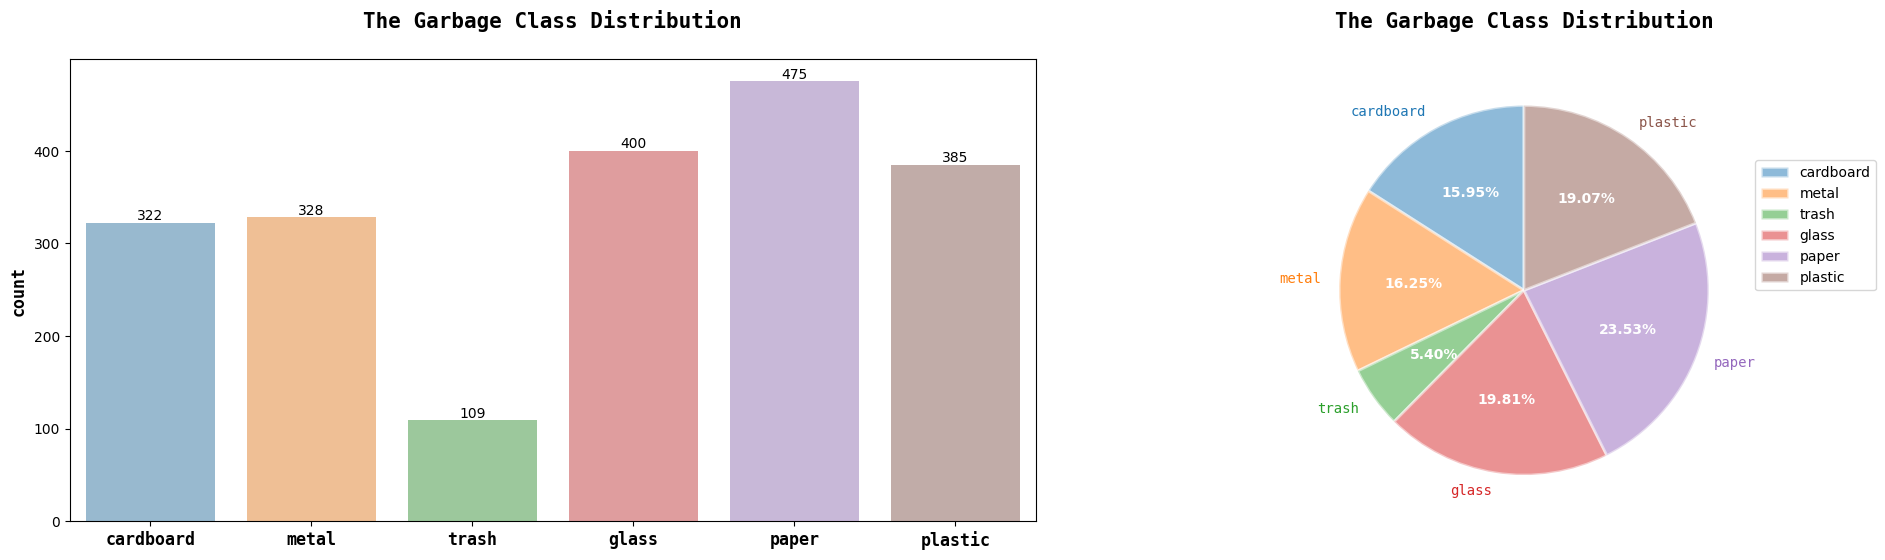

In [79]:
%matplotlib inline
fig,axes = plt.subplots(1,2,figsize=(25,6), gridspec_kw=dict(wspace=0.005))
sns.barplot(data=garbage_df, x='garbage_class', y='garbage_count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)
    
axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The Garbage Class Distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(garbage_df['garbage_count'], labels=garbage_df['garbage_class'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The Garbage Class Distribution\n', font='monospace', weight='semibold', size=15);

In [80]:
def create_yolo_boundbox(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower = np.array([20,20,20], dtype='uint8')
    upper = np.array([200,200,200],dtype='uint8')
    img = cv2.inRange(image, lower, upper)
    
    
    img = cv2.blur(img, (2,2))
    ret, thres = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_not(thres)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv2.contourArea(x))
    
    # get bounding box coordinates
    xmin, ymin, xmax, ymax = cv2.boundingRect(countours)
    dimensions = img.shape
    h = img.shape[0]
    w = img.shape[1]
    
    # to calculate bndBox info for yolov5
    xp = (xmin + (xmax-xmin)/2) * 1.0 /w
    yp = (ymin + (ymax- ymin )/2 ) *1.0 /h
    wp = (xmax - xmin) * 1.0 / w
    hp = (ymax - ymin ) *1.0 / h
    
    return xp, yp, wp, hp
    
    